# 1. Make predictions on a pre-trained model
## Key Points:
1. Data Loading and Preprocessing: Loads the CIFAR-10 dataset, normalizes the data, and one-hot encodes the labels.
2. Model Definition: Loads the pre-trained VGG16 model without the top layer and adds custom dense layers for CIFAR-10 classification.
3. Layer Freezing: Freezes all layers of the VGG16 base model to prevent them from being trained (no fine-tuning).
4. Model Compilation: Compiles the model with the Adam optimizer and categorical cross-entropy loss.
5. Training with Progress Bar: Trains the model with a progress bar for visual feedback.
6. Evaluation: Evaluates the model on the test dataset and prints out the performance metrics in a tabulated format.
* This code represents a minimalistic approach to transfer learning, where the pre-trained model is used as a feature extractor without any further training of its layers.

Training the model


Epoch 1/10: 50016samples [01:05, 768.80samples/s]                       
Epoch 2/10: 50016samples [01:04, 772.89samples/s]                       
Epoch 3/10: 50016samples [01:05, 758.54samples/s]                       
Epoch 4/10: 50016samples [01:08, 729.62samples/s]                       
Epoch 5/10: 50016samples [01:14, 668.15samples/s]                       
Epoch 6/10: 50016samples [01:21, 610.65samples/s]                       
Epoch 7/10: 50016samples [01:28, 563.61samples/s]                       
Epoch 8/10: 50016samples [01:38, 508.18samples/s]                       
Epoch 9/10: 50016samples [01:45, 472.80samples/s]                       
Epoch 10/10: 50016samples [01:44, 480.38samples/s]                      


+---------------------+--------+
|       Metric        | Value  |
+---------------------+--------+
|     Train Loss      | 1.1457 |
|   Train Accuracy    | 0.6049 |
|   Validation Loss   | 1.1979 |
| Validation Accuracy | 0.5867 |
|      Test Loss      | 1.1979 |
|    Test Accuracy    | 0.5867 |
+---------------------+--------+
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Precision | 0.5871 |
|  Recall   | 0.5867 |
| F1 Score  | 0.5847 |
+-----------+--------+


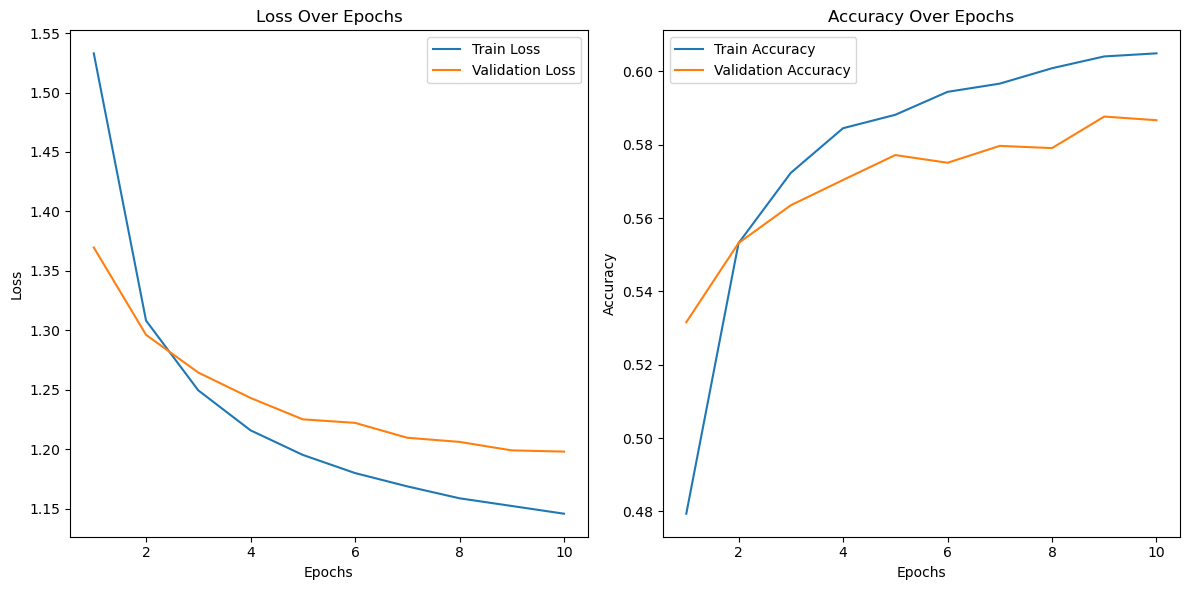

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tabulate import tabulate
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
predictions = Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set training parameters
num_epochs = 10
batch_size = 32

# Initialize lists to track the metrics over epochs
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []

# Train the model with a progress bar
print("Training the model")
for epoch in range(num_epochs):
    with tqdm(total=len(x_train), desc=f"Epoch {epoch+1}/{num_epochs}", unit="samples") as pbar:
        history = model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=1,
            validation_data=(x_test, y_test),
            verbose=0,
            callbacks=[tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch, logs: pbar.update(batch_size))]
        )
        
    # Collect metrics from this epoch
    all_train_loss.append(history.history['loss'][0])
    all_val_loss.append(history.history['val_loss'][0])
    all_train_accuracy.append(history.history['accuracy'][0])
    all_val_accuracy.append(history.history['val_accuracy'][0])

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Prepare data for tabulate
table_data = [
    ["Metric", "Value"],
    ["Train Loss", f"{all_train_loss[-1]:.4f}"],
    ["Train Accuracy", f"{all_train_accuracy[-1]:.4f}"],
    ["Validation Loss", f"{all_val_loss[-1]:.4f}"],
    ["Validation Accuracy", f"{all_val_accuracy[-1]:.4f}"],
    ["Test Loss", f"{loss:.4f}"],
    ["Test Accuracy", f"{accuracy:.4f}"]
]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))

# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)

# Prepare data for tabulate
extra_table_data = [
    ["Metric", "Value"],
    ["Precision", f"{precision:.4f}"],
    ["Recall", f"{recall:.4f}"],
    ["F1 Score", f"{f1:.4f}"]
]

# Print the updated table
print(tabulate(extra_table_data, headers="firstrow", tablefmt="pretty"))

# Create plots for the collected history
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(all_train_loss) + 1), all_train_loss, label='Train Loss')
plt.plot(range(1, len(all_val_loss) + 1), all_val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(all_train_accuracy) + 1), all_train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(all_val_accuracy) + 1), all_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Fine-tune the pre-trained model
## Key Points:
1. **Data Loading and Preprocessing**: Loads the CIFAR-10 dataset, normalizes the data, and one-hot encodes the labels.
2. **Model Definition**: Loads the pre-trained VGG16 model without the top layer and adds custom dense layers for CIFAR-10 classification.
3. **Layer Freezing**: Initially freezes all layers of the VGG16 base model to prevent them from being trained during the initial training phase.
4. **Initial Training**: Trains the model with the base model layers frozen.
5. **Layer Unfreezing**: Unfreezes the last 4 layers of the base model for fine-tuning.
6. **Fine-Tuning Training**: Trains the model with some of the base model layers unfrozen.
7. **Evaluation**: Evaluates the model on the test dataset and prints out the performance metrics in a tabulated format.
* This approach allows the model to first learn the new task with the pre-trained weights and then fine-tune some of the deeper layers for potentially better performance.

Training the model (initially frozen)


Epoch 1/5: 50016samples [01:44, 476.82samples/s]                      
Epoch 2/5: 50016samples [01:42, 487.05samples/s]                      
Epoch 3/5: 50016samples [01:45, 476.05samples/s]                       
Epoch 4/5: 50016samples [01:44, 477.77samples/s]                      
Epoch 5/5: 50016samples [01:38, 509.02samples/s]                      


Fine-tuning the model


Epoch 1/10: 50016 samples [03:05, 269.51 samples/s]                     
Epoch 2/10: 50016 samples [03:02, 274.50 samples/s]                     
Epoch 3/10: 50016 samples [02:49, 295.84 samples/s]                     
Epoch 4/10: 50016 samples [02:43, 306.43 samples/s]                     
Epoch 5/10: 50016 samples [02:42, 307.10 samples/s]                     
Epoch 6/10: 50016 samples [02:41, 309.35 samples/s]                     
Epoch 7/10: 50016 samples [02:40, 311.39 samples/s]                     
Epoch 8/10: 50016 samples [02:41, 309.63 samples/s]                     
Epoch 9/10: 50016 samples [02:44, 304.09 samples/s]                     
Epoch 10/10: 50016 samples [02:13, 373.34 samples/s]                     


+---------------------+--------+
|       Metric        | Value  |
+---------------------+--------+
|     Train Loss      | 0.2549 |
|   Train Accuracy    | 0.9229 |
|   Validation Loss   | 0.8172 |
| Validation Accuracy | 0.7372 |
|      Test Loss      | 0.8172 |
|    Test Accuracy    | 0.7372 |
+---------------------+--------+
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
+-----------+--------+
|  Metric   | Value  |
+-----------+--------+
| Precision | 0.7483 |
|  Recall   | 0.7372 |
| F1 Score  | 0.7402 |
+-----------+--------+


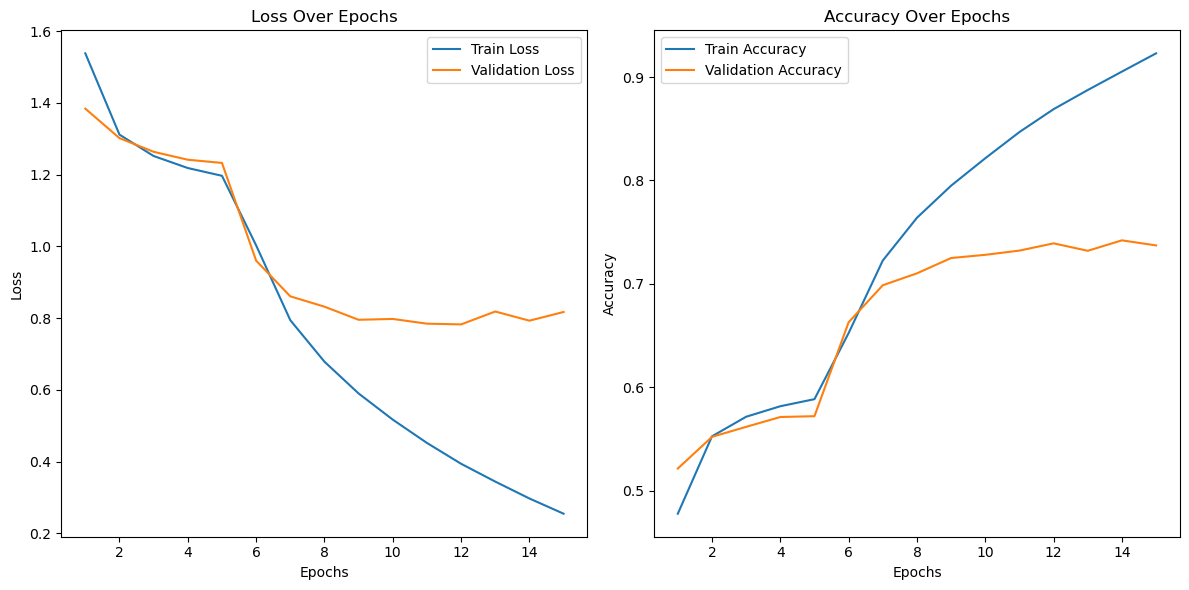

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tabulate import tabulate
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom top layers
x = base_model.output
x = Flatten()(x)
predictions = Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (initially with frozen base model layers)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Initialize lists to track the metrics over epochs
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []

# Training parameters
initial_epochs = 5
batch_size = 32

print("Training the model (initially frozen)")
for epoch in range(initial_epochs):
    with tqdm(total=len(x_train), desc=f"Epoch {epoch+1}/{initial_epochs}", unit="samples") as pbar:
        history = model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=1,
            validation_data=(x_test, y_test),
            verbose=0,
            callbacks=[tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch, logs: pbar.update(batch_size))]
        )
        
    # Collect metrics from this epoch
    all_train_loss.append(history.history['loss'][0])
    all_val_loss.append(history.history['val_loss'][0])
    all_train_accuracy.append(history.history['accuracy'][0])
    all_val_accuracy.append(history.history['val_accuracy'][0])

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

# Recompile the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning training
fine_tuning_epochs = 10

print("Fine-tuning the model")
for epoch in range(fine_tuning_epochs):
    with tqdm(total=len(x_train), desc=f"Epoch {epoch+1}/{fine_tuning_epochs}", unit=" samples") as pbar:
        history = model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=1,
            validation_data=(x_test, y_test),
            verbose=0,
            callbacks=[tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch, logs: pbar.update(batch_size))]
        )

    # Collect metrics from this epoch
    all_train_loss.append(history.history['loss'][0])
    all_val_loss.append(history.history['val_loss'][0])
    all_train_accuracy.append(history.history['accuracy'][0])
    all_val_accuracy.append(history.history['val_accuracy'][0])

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Prepare data for tabulate
table_data = [
    ["Metric", "Value"],
    ["Train Loss", f"{all_train_loss[-1]:.4f}"],
    ["Train Accuracy", f"{all_train_accuracy[-1]:.4f}"],
    ["Validation Loss", f"{all_val_loss[-1]:.4f}"],
    ["Validation Accuracy", f"{all_val_accuracy[-1]:.4f}"],
    ["Test Loss", f"{loss:.4f}"],
    ["Test Accuracy", f"{accuracy:.4f}"]
]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="pretty"))

# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division=1)

# Prepare data for tabulate
extra_table_data = [
    ["Metric", "Value"],
    ["Precision", f"{precision:.4f}"],
    ["Recall", f"{recall:.4f}"],
    ["F1 Score", f"{f1:.4f}"]
]

# Print the updated table
print(tabulate(extra_table_data, headers="firstrow", tablefmt="pretty"))

# Create plots for the collected history
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(all_train_loss) + 1), all_train_loss, label='Train Loss')
plt.plot(range(1, len(all_val_loss) + 1), all_val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(all_train_accuracy) + 1), all_train_accuracy, label='Train Accuracy')
plt.plot(range(1, len(all_val_accuracy) + 1), all_val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()